## MultiPEC Application to CNN: Validation of Networks by Pruning

#### This notebook tests the pruned CNN models and calculates class specificity of pruned networks.

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import patches
from pickle import load
import os
from pathlib import Path
from multipec.simulation_utils import set_plotting_style

def find_repo_root(marker="setup.py"):
    path = Path.cwd()
    while not (path / marker).exists() and path != path.parent:
        path = path.parent
    return path

project_root = find_repo_root()

In [157]:
ext = "_05up"

results_folder = project_root/"data/results/cnn/"
figures_folder = project_root/"data/figures/cnn/"
os.makedirs(figures_folder, exist_ok=True)

filename = f"pruned{ext}.xlsx"

IDX_TO_LABEL = {0: '0 - zero', 1: '1 - one', 2: '2 - two', 3: '3 - three', 4: '4 - four', 5: '5 - five', 6: '6 - six', 7: '7 - seven', 8: '8 - eight', 9: '9 - nine'}

Plot the accuracy change on the testing set:

/tmp/ipykernel_9735/4069259583.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")
/home/kivi/miniconda3/envs/xnn/lib/python3.9/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


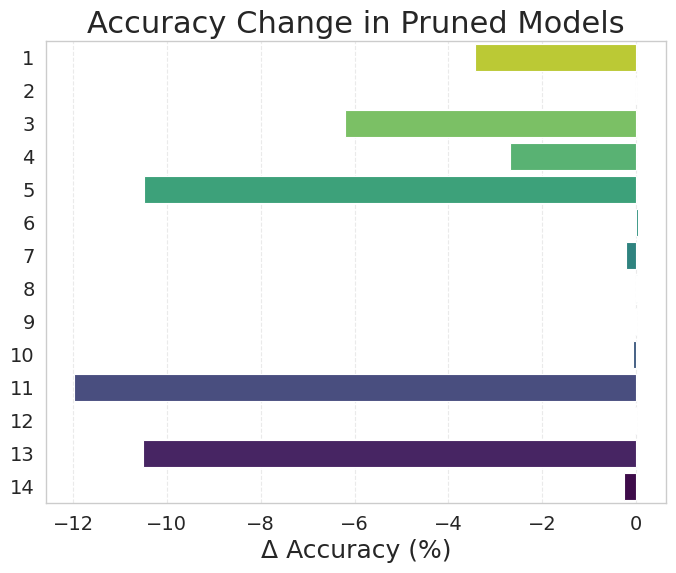

In [161]:
from matplotlib import cm

a_col = pd.read_excel(results_folder/filename, usecols="C:D")
a_model = list(a_col["Overall_Accuracy"])[0]
a_pruned = list(a_col["Overall_Accuracy"])[1::]

a_change = [(a-a_model)*100 for a in a_pruned]
subnet_ids = list(a_col["Subnet_ID"])[1::]

set_plotting_style()

cmap = cm.get_cmap("viridis")
custom_colors = [cmap(i / len(a_change)) for i in range(len(a_change))][::-1]

plt.figure(figsize=(8,6))
plot = sns.barplot(x=a_change, y=subnet_ids, orient="h", palette=custom_colors)
plot.xaxis.grid(True)
plot.set_yticklabels([str(int(i)) for i in subnet_ids])
plot.set_title("Accuracy Change in Pruned Models")
plt.xlabel("Δ Accuracy (%)")
# Save high-res
plt.savefig(figures_folder/f"dAccuracy{ext}.png", dpi=300)

plt.show()


Load the class-specific accuracy change. Skip the first row as it contains NaNs (this is a manually added row containing the original model's accuracy values).

In [144]:
df = pd.read_excel(results_folder/filename, usecols="R:AA", skiprows=lambda x:x in [1]) 

Load subnets:

In [145]:
output_path = project_root/"data/output/cnn/"

conv_layers = {2:10, 3:20}

loaded_nets = load(open(output_path/f"nets{ext}.p", "rb"))

idx_net_dict, idx_err_dict = {}, {}
net_err_dict = {}
idx=0

net_errors, pair_errors = [],[]

for n in loaded_nets:
    if len(n[0])>2: # consider only nets (not pairs)

        net_err_dict[n[0]] = n[1][-1]
        net_errors.append(n[1][-1])
        pair_errors.append(n[1][0])

        idx_net_dict[idx] = n[0]
        idx_err_dict[idx] = n[1][-1]
        idx+=1

print("Number of subnets excluding pairs:", len(idx_net_dict))
print(idx_net_dict)


Number of subnets excluding pairs: 41
{0: (4, 8, 2, 5), 1: (9, 7, 2, 4, 8), 2: (7, 3, 9, 4, 24, 5, 8, 1, 26, 2), 3: (16, 21, 2, 13, 22), 4: (16, 24, 27, 21), 5: (11, 24, 22, 16, 27, 7), 6: (17, 11, 1, 14, 26, 12), 7: (22, 15, 27, 13, 24), 8: (0, 6, 26, 4, 9, 2, 5, 29, 8, 23), 9: (0, 3, 18, 29, 7), 10: (7, 8, 16, 0, 27), 11: (7, 5, 9, 4, 25, 2, 12), 12: (7, 2, 9, 4, 25, 5), 13: (18, 16, 28, 14, 12, 20), 14: (0, 9, 1, 18), 15: (20, 8, 9, 6), 16: (20, 2, 8, 9, 25, 12, 6, 5, 3), 17: (0, 8, 9, 6, 27, 4, 5), 18: (20, 5, 9, 25, 12, 2, 6), 19: (0, 5, 9, 29, 4, 7, 8, 2, 3), 20: (16, 27, 8, 9, 18, 4, 2), 21: (20, 3, 9, 27, 4, 6, 8, 19, 2), 22: (23, 29, 14, 21, 22), 23: (9, 27, 3, 16), 24: (0, 2, 9, 29, 7, 4, 8, 5, 3), 25: (4, 7, 2, 3), 26: (21, 22, 24, 27), 27: (23, 14, 29, 4, 20, 5, 8, 0, 9, 2), 28: (14, 15, 26, 25, 18), 29: (20, 6, 12, 25, 2, 9, 5), 30: (18, 12, 22, 16, 10), 31: (20, 9, 27, 4, 6), 32: (0, 4, 18, 9, 5), 33: (20, 4, 8, 18, 27, 5), 34: (12, 11, 16, 14), 35: (18, 10, 22, 16), 36: 

Compute correlation between the initial node pair error and the final net error:

PEC[2]-PEC[n] correlation = 0.8863388476112678


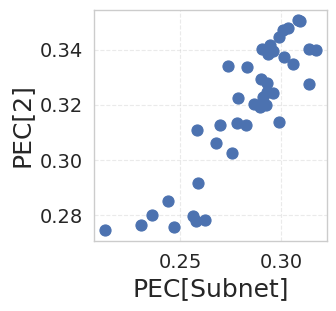

In [146]:
plt.figure(figsize=(3,3))
plt.scatter(net_errors, pair_errors)
plt.xlabel("PEC[Subnet]")
plt.ylabel("PEC[2]") #PEC node pair

corr = np.corrcoef(net_errors, pair_errors)
print("PEC[2]-PEC[n] correlation =", corr[0][1])
plt.show()

Plot net errors in order as they are generated during the analysis (index):

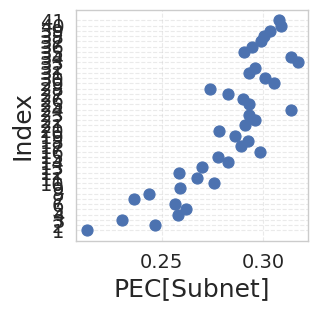

In [147]:
plt.figure(figsize=(3,3))
plt.scatter(net_errors, list(range(len(net_errors))))
plt.xlabel("PEC[Subnet]")
plt.ylabel("Index")
plt.yticks(ticks=list(range(len(loaded_nets))), labels=list(range(1,len(loaded_nets)+1)))
plt.show()

Plot the accuracy change per class:

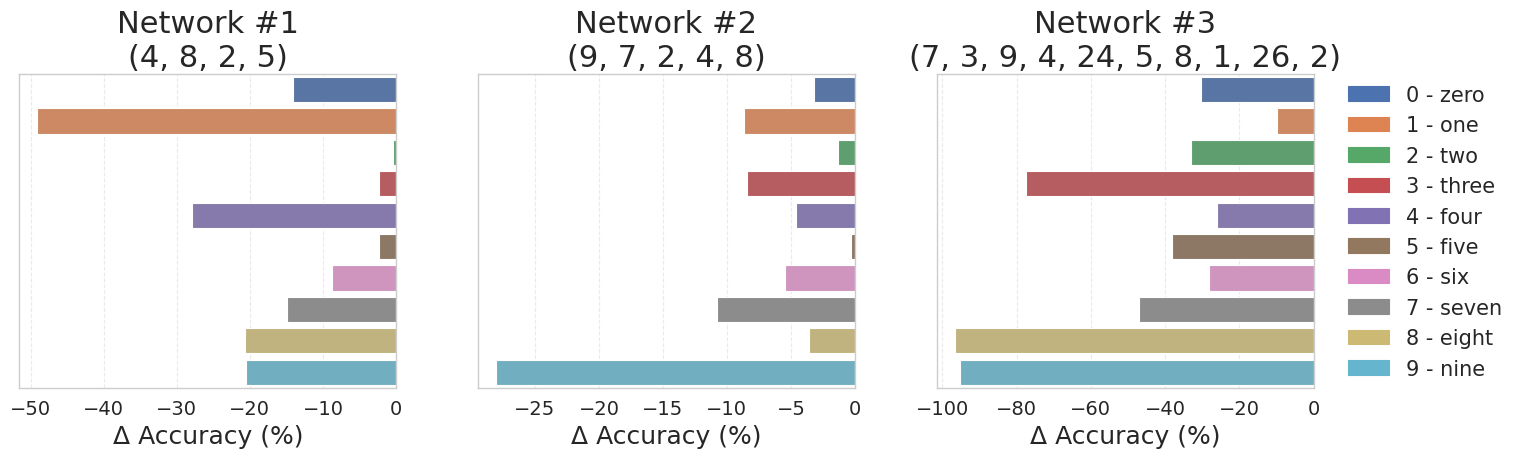

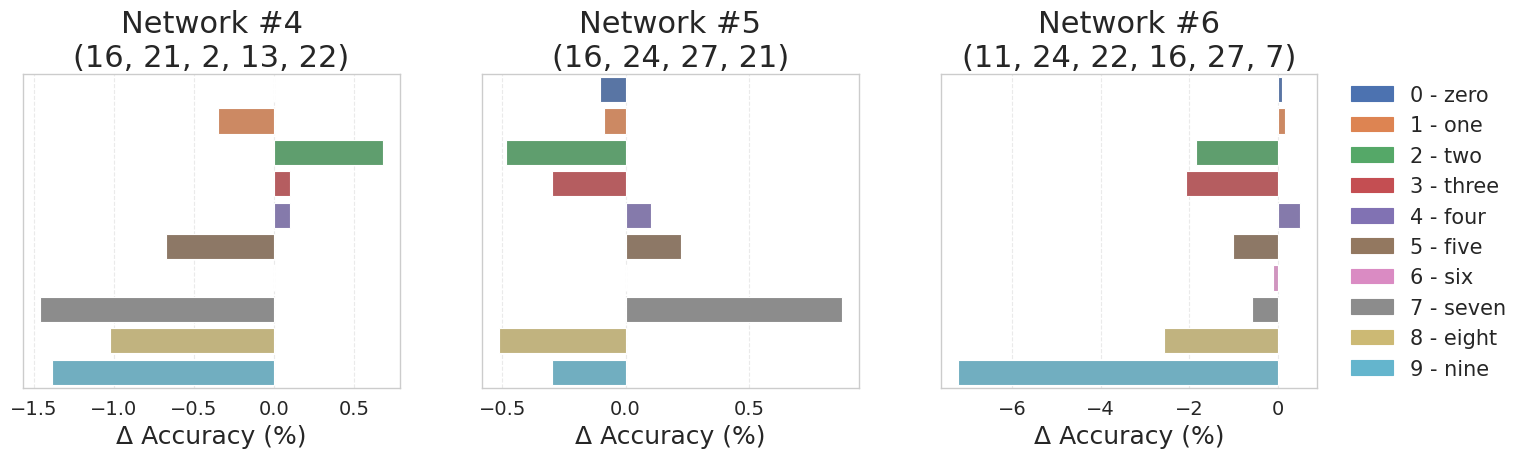

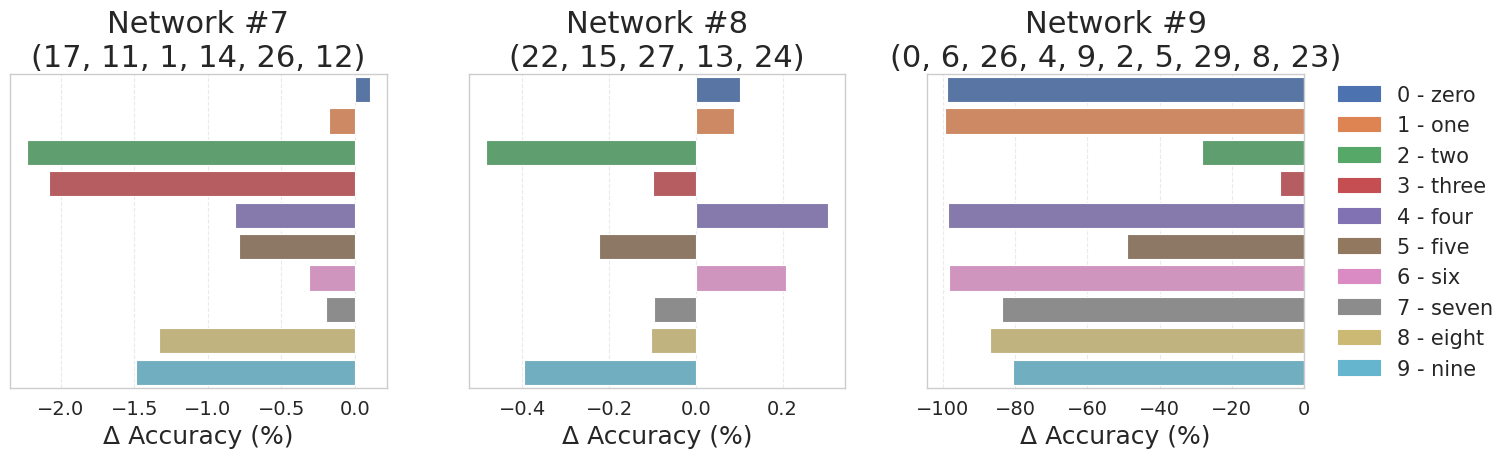

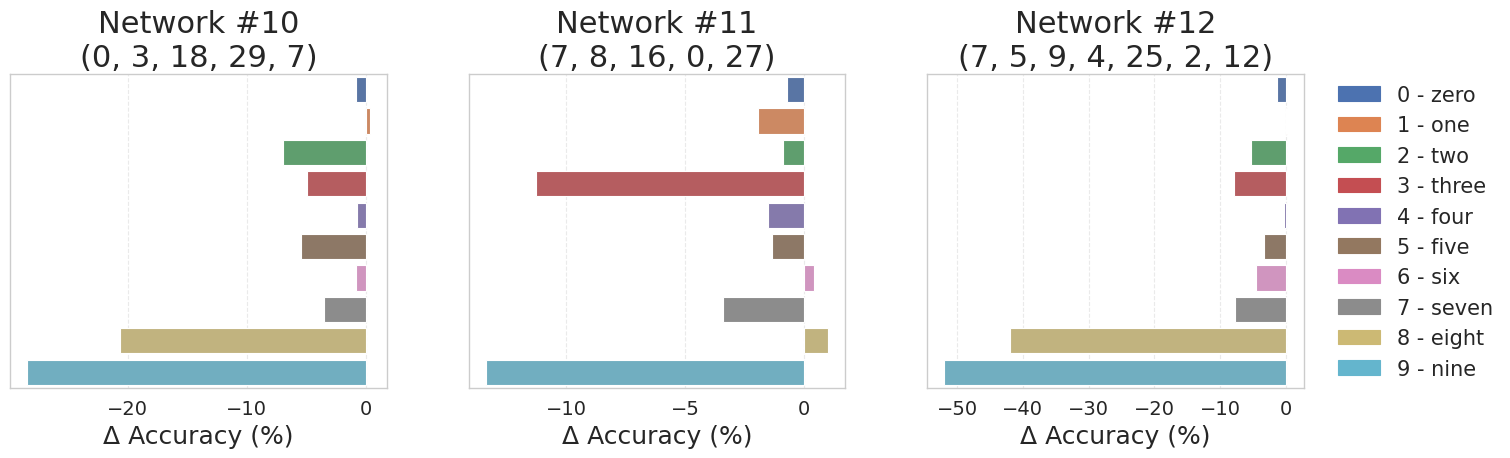

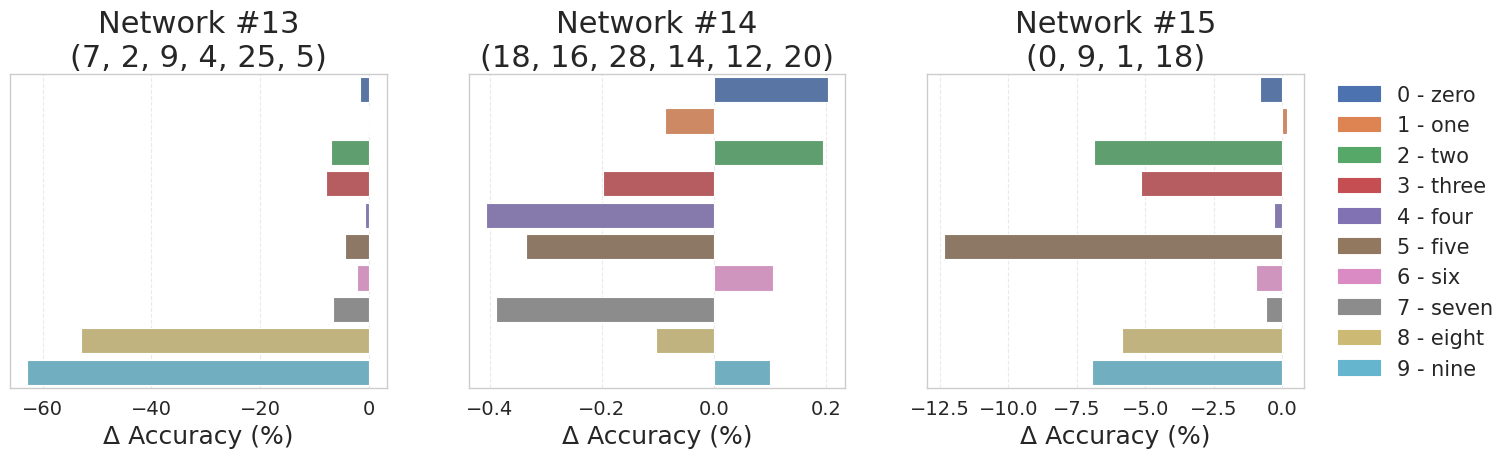

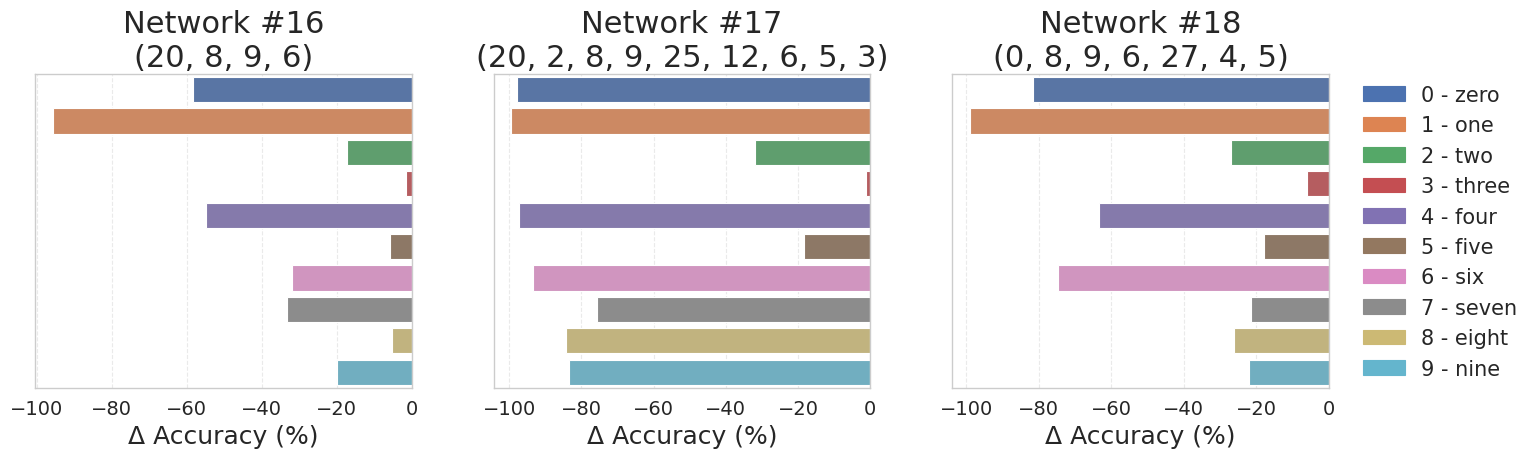

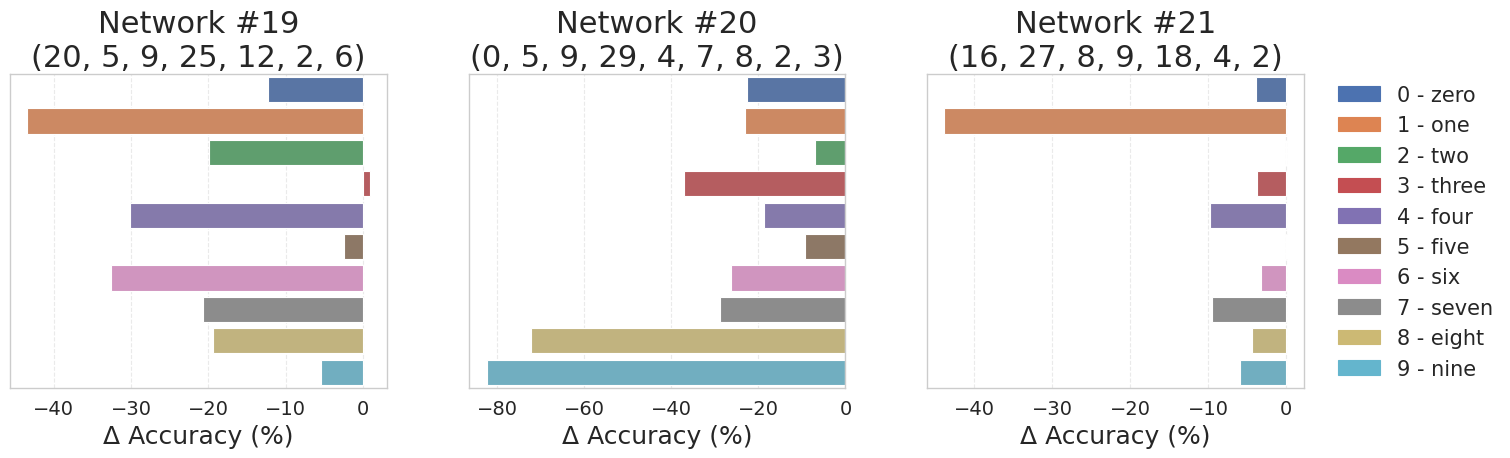

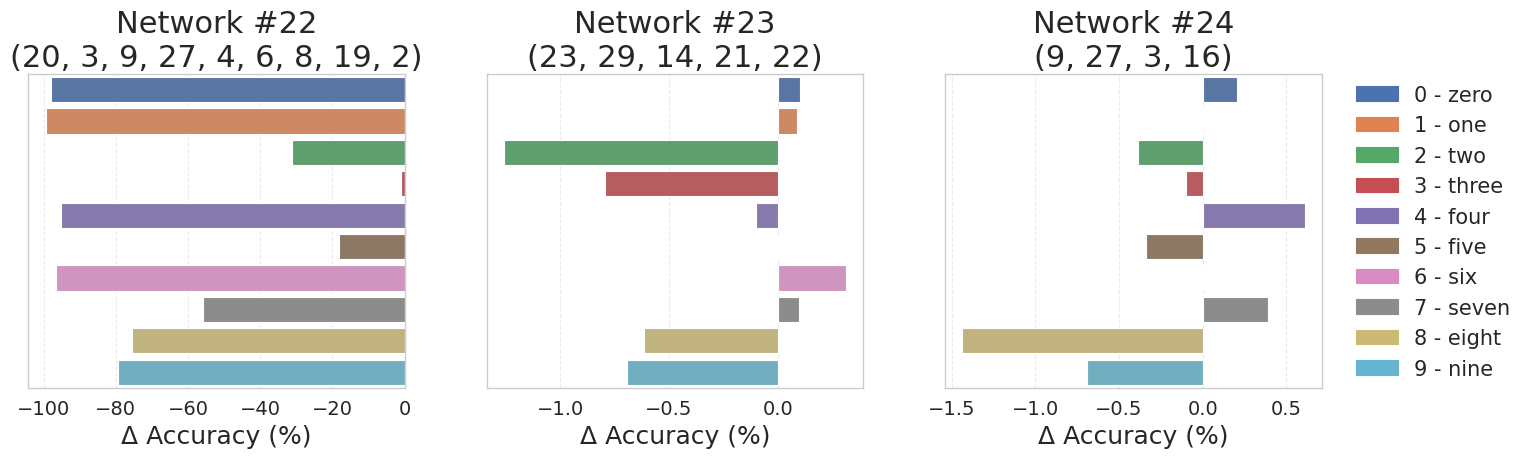

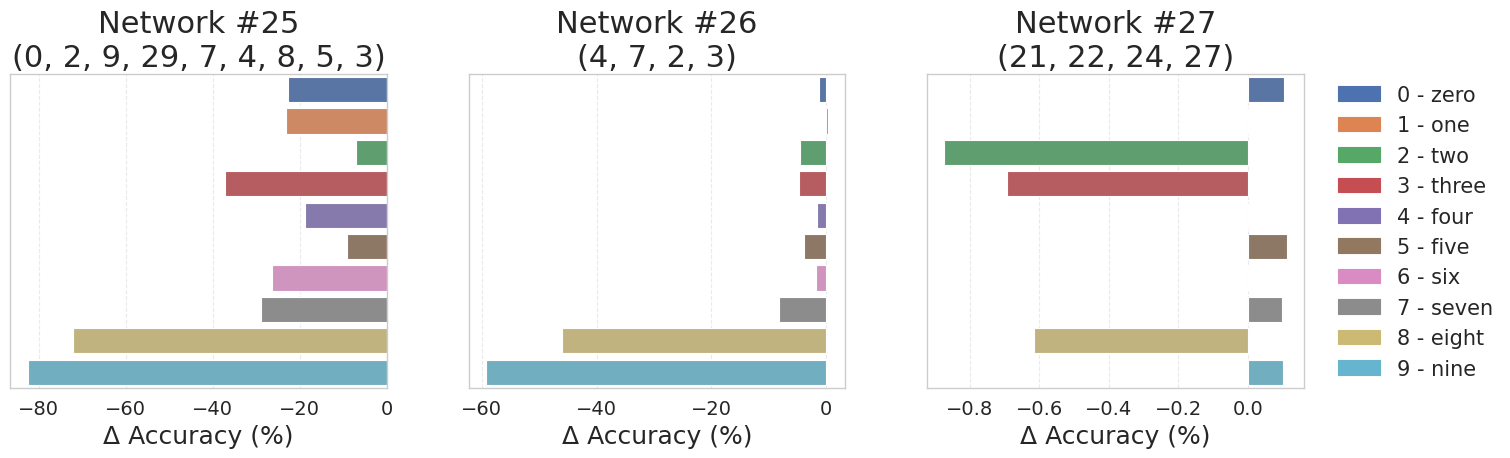

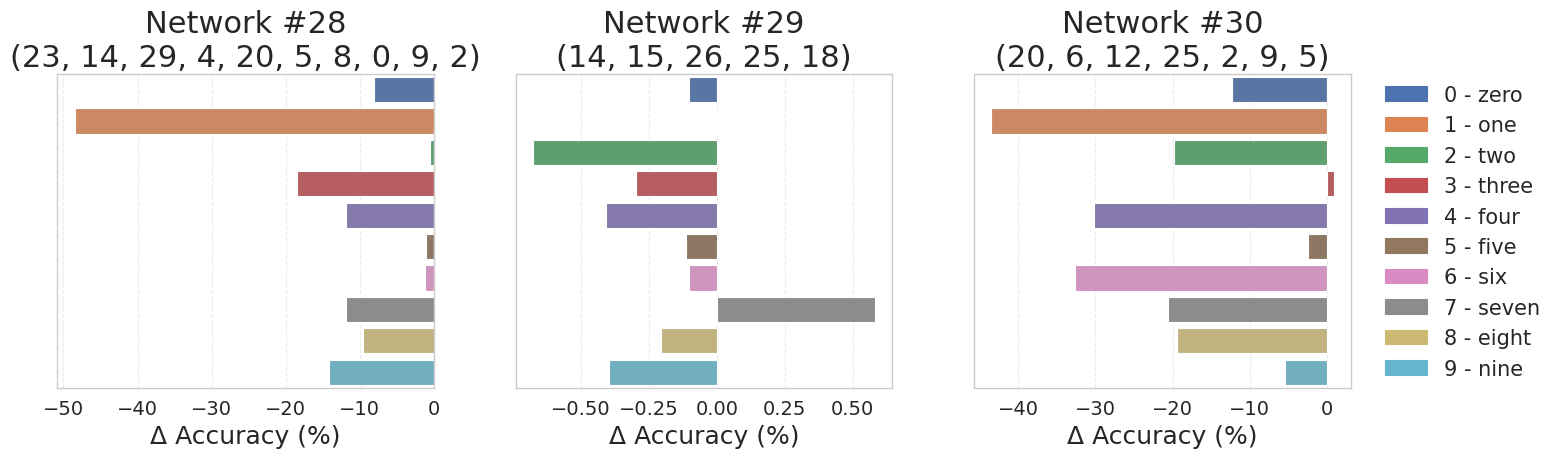

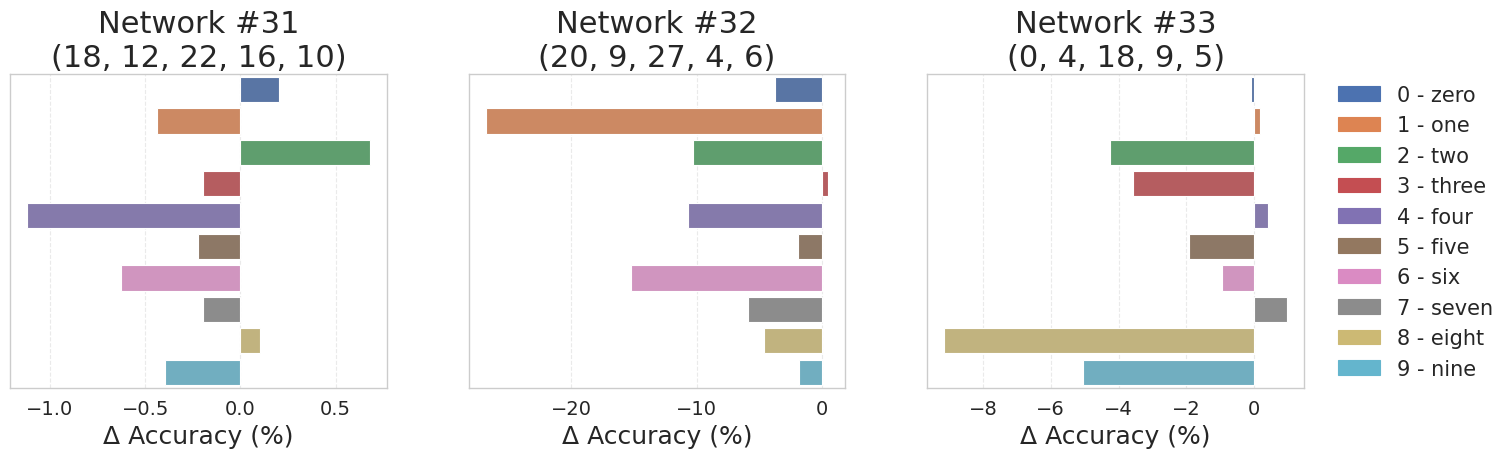

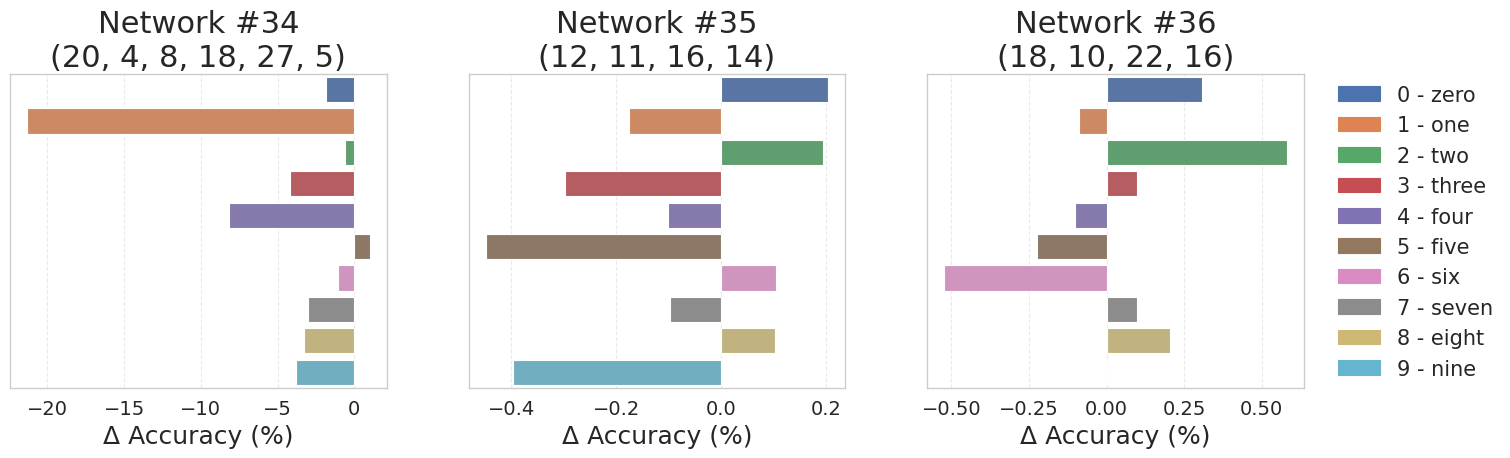

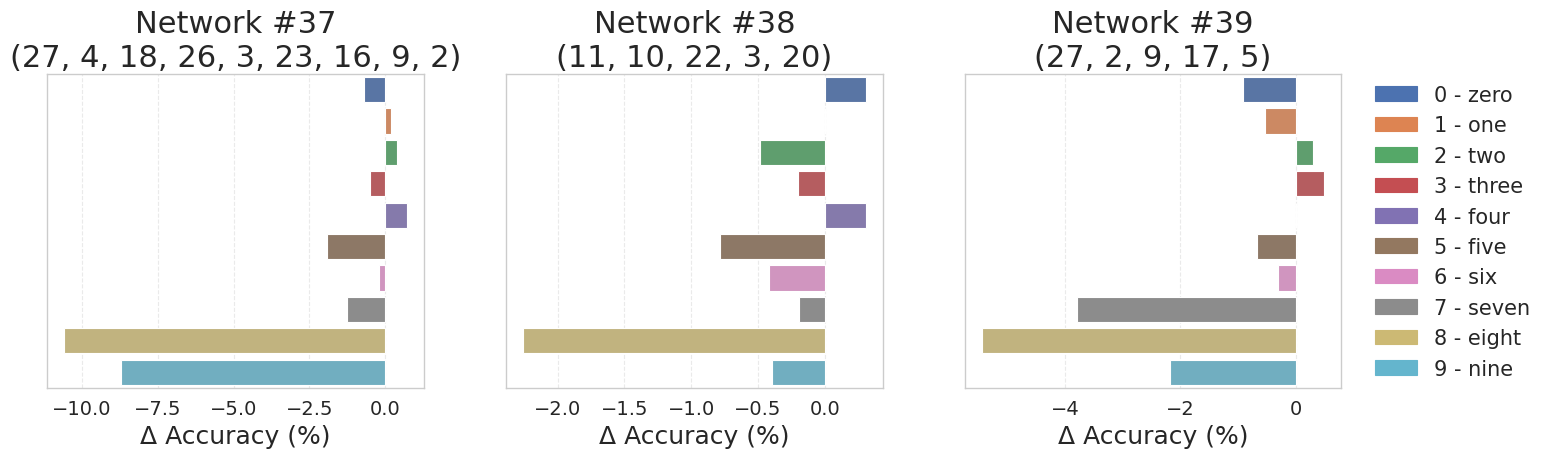

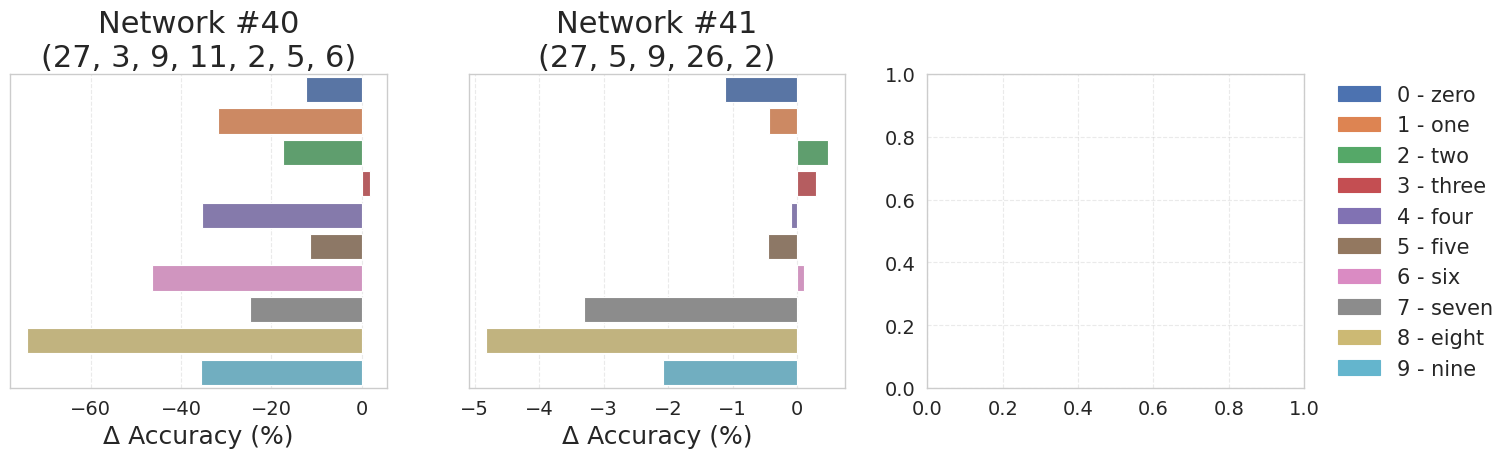

In [148]:
set_plotting_style()

def barh_subplot(row, index, ax):
    x_vals = row.to_numpy()
    y_vals = np.array(list(IDX_TO_LABEL.values()))

    plot = sns.barplot(x=x_vals, y=y_vals, orient="h", ax=ax)

    p = [patches.Patch(color=sns.color_palette()[i], label=t) 
         for i, t in enumerate(t.get_text() for t in plot.get_yticklabels())]

    plt.legend(handles=p, bbox_to_anchor=(1.55, 1.025), loc="upper right")
    plot.xaxis.grid(True)
    plot.set_yticklabels([])
    plot.set_yticks([])
    plot.set_title(f"Network #{index+1}\n{idx_net_dict[index]}")
    ax.set_xlabel("Δ Accuracy (%)")
    return plot

fig_size = (14,4)
fig, ax = plt.subplots(1, 3, figsize=fig_size)
fig.tight_layout()

cnt=0
for index, row in df.iterrows():
    if cnt>2:
        cnt=0
        fig, ax = plt.subplots(1, 3, figsize=fig_size)
        fig.tight_layout()
    barh_subplot(row, index, ax[cnt])
    cnt+=1
    if (index+1)%3 == 0 and index != 0:
        # Save high-res
        plt.savefig(figures_folder/f"Class_Accuracy{ext}_{index}.png", dpi=300)

plt.show()

Pruning which subnets most decreases the accuracy for each class? These subnets are most important for classification.

In [149]:
putative_nets_errs = {}
net_class_dict = {}
idx_class_dict = {}

for name, val in df.items():
    class_name = name[1::]
    idx = int(df[name].idxmin())

    d_accuracy = min(val)

    net = idx_net_dict[idx]
    err = idx_err_dict[idx]
    
    if err not in putative_nets_errs: putative_nets_errs[err] = 1
    elif err in putative_nets_errs: putative_nets_errs[err] += 1

    if net not in net_class_dict: net_class_dict[net] = [(class_name)]
    else: net_class_dict[net].append((class_name))

    if idx not in idx_class_dict: idx_class_dict[idx] = [(class_name, d_accuracy)]
    else: idx_class_dict[idx].append((class_name, d_accuracy))

print(net_class_dict)
print(idx_class_dict)

print(putative_nets_errs)

{(0, 6, 26, 4, 9, 2, 5, 29, 8, 23): ['0 - zero', '1 - one', '4 - four', '5 - five', '6 - six', '7 - seven'], (7, 3, 9, 4, 24, 5, 8, 1, 26, 2): ['2 - two', '3 - three', '8 - eight', '9 - nine']}
{8: [('0 - zero', -98.97959184), ('1 - one', -99.38325991), ('4 - four', -98.57433809), ('5 - five', -48.99103139), ('6 - six', -98.32985386), ('7 - seven', -83.56031128)], 2: [('2 - two', -33.04263566), ('3 - three', -77.62376238), ('8 - eight', -96.71457906), ('9 - nine', -95.24281467)]}
{0.2588312359652326: 6, 0.2303773429028734: 4}


Where in the error distribution do the putative subnets fall? 

Minimum error: 0.21273143333943145
Maximum error: 0.3172247631365102
Mean error = 0.2816149542785583
Median error = 0.2900448851532226
Sigma = 0.02406808945651098


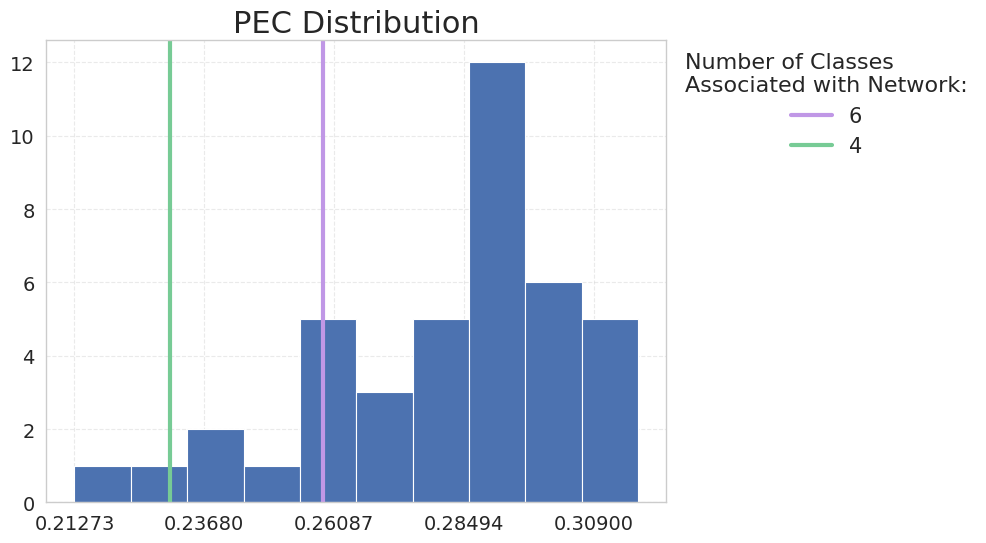

In [150]:
set_plotting_style()

all_errors = list(idx_err_dict.values())

print("Minimum error:", min(all_errors))
print("Maximum error:", max(all_errors))

print("Mean error =", np.mean(all_errors))
print("Median error =", np.median(all_errors))
print("Sigma =", np.std(all_errors))

plt.hist(all_errors, bins=10)
for e in list(putative_nets_errs.keys()):
    plt.axvline(x = e, color = np.random.rand(3,), label = f"{putative_nets_errs[e]}")
plt.legend(bbox_to_anchor = (1.0, 1.015), loc = 'upper left', title = "Number of Classes\nAssociated with Network:")
plt.xticks(list(np.arange(min(all_errors), max(all_errors), np.std(all_errors))))
plt.title(f"PEC Distribution")
plt.show()

Which are the putative unimportant nodes?

In [151]:
node_ids = list(range(sum(conv_layers.values())))
important_nodes = [item for subl in list(net_class_dict.keys()) for item in subl]

unimportant_nodes = list(set(node_ids) - set(important_nodes))
print(unimportant_nodes)
print("Number of unimportant nodes:", len(unimportant_nodes))

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 27, 28]
Number of unimportant nodes: 16


Check correlation between subnetwork size and accuracy change:

<function matplotlib.pyplot.show(close=None, block=None)>

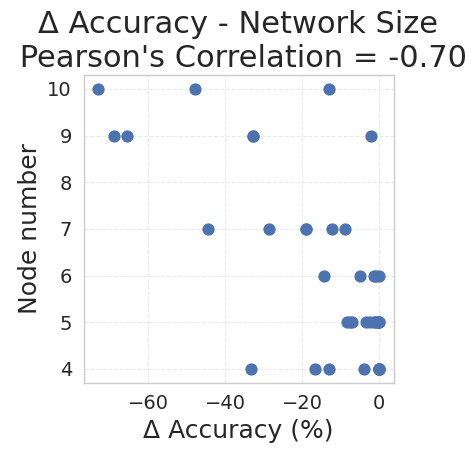

In [152]:
set_plotting_style()

plt.figure(figsize=(4,4))
plt.scatter(a_change, [len(net) for net in idx_net_dict.values()])

corr = np.corrcoef(a_change, [len(net) for net in idx_net_dict.values()])
plt.ylabel("Node number")
plt.xlabel("Δ Accuracy (%)")
plt.title(f"Δ Accuracy - Network Size\n Pearson's Correlation = {corr[0][1]:.2f}")
plt.show

Check shared nodes between classes:

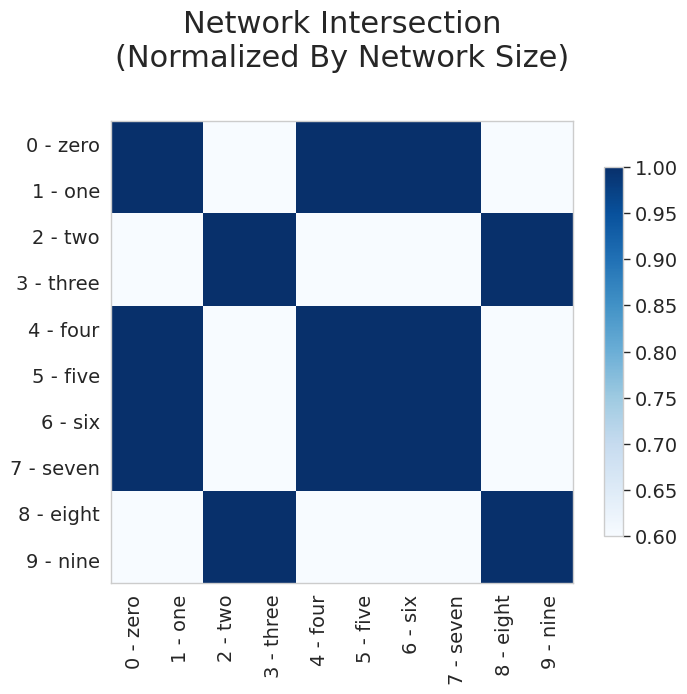

In [153]:
set_plotting_style()

class_net_dict = {}
for class_net, classes in net_class_dict.items():
    for c in classes: class_net_dict[c] = class_net

class_net_dict = dict(sorted(class_net_dict.items()))

subnet_intersection = np.zeros((10,10))

for x,class1 in enumerate(class_net_dict):
    snet1 = class_net_dict[class1]
    for y,class2 in enumerate(class_net_dict):
        snet2 = class_net_dict[class2]

        n_intersection = len(set(snet1).intersection(snet2))/len(snet1)
        subnet_intersection[x][y] = n_intersection

plt.figure()
plt.grid(False)
plt.imshow(subnet_intersection, cmap='Blues', interpolation='nearest')
plt.xticks(ticks=list(range(10)), labels=list(class_net_dict.keys()), rotation=90)
plt.yticks(ticks=list(range(10)), labels=list(class_net_dict.keys()))
plt.title(f"Network Intersection\n(Normalized By Network Size)", x=0.5, y=1.1)
plt.colorbar(shrink=0.8)
plt.show()